# Лабораторная работа №3
# Кластеризация данных

**Цель работы: изучить алгоритмы и методы кластерного анализа на практике.**


### Вариант задания:
	Вариант №15. Фитнес клуб
	Содержит информацию о посетителях фитнес клуба
1. Пол
2. Близкое расположение
3. Сотрудник компании партнера
4. По промо друзей
5. Указан ли телефон
6. Длительность текущего абонемента
7. Посещение групповых занятий
8. Возраст
9. Средние траты на доп услуги
10. Количество месяцев до окончания абонемента
11. Время с момента первого обращения в фитнес-центр (в месяцах) 
12. Средняя частота посещений
13. Средняя частота посещений в месяц
14. Ушел ли из фитнес клуба


В начале, импортируем все необходимые для работы библиотеки, а также импортируем набор данных.

In [3]:
import pandas as pd
import numpy as np 
from pandas import DataFrame
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import DistanceMetric
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_rows = 4000
%matplotlib inline
df = pd.read_csv('5gym_churn.csv')
df = df.rename(columns={'gender':'Gender'})
df

Gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0          1              1        1              1      0                6   
1          0              1        0              0      1               12   
2          0              1        1              0      1                1   
3          0              1        1              1      1               12   
4          1              1        1              1      1                1   
5          1              1        0              0      1                1   
6          1              1        1              1      0                6   
7          0              1        0              0      1                1   
8          1              1        1              1      1                1   
9          0              1        0              0      1                1   
10         0              1        0              0      0                6   
11         1              1        1              0      1                1   
12         0              1        1              1      1                1   
13         1              1        0              0      1                1   
14         0              1        0              0      1                6   
15         0              1        1              1      1               12   
16         0              1        1              1      1                1   
17         0              1        0              1      1                6   
18         0              1        0              0      1                1   
19         1              1        1              1      1               12   
20         1              1        0              0      1                6   
21         0              0        0              0      1                1   
22         1              1        0              0      1               12   
23         1              1        0              0      1                1   
24         0              1        0              1      0                6   
25         0              0        0              0      1                1   
26         0              1        1              0      1                6   
27         1              1        0              1      1                6   
28         0              1        0              0      1                1   
29         0              1        1              1      1                6   
30         0              1        1              0      1                1   
31         0              1        0              0      1               12   
32         0              1        0              0      1               12   
33         0              1        1              1      1               12   
34         0              1        0              0      1                6   
35         0              1        0              0      1               12   
36         0              1        0              0      0                1   
37         1              1        0              0      1                1   
38         1              1        1              1      1               12   
39         1              1        0              1      0                6   
40         0              1        1              1      1               12   
41         0              1        1              1      0                1   
42         0              1        0              0      1               12   
43         0              1        1              1      0                1   
44         1              1        1              0      1               12   
45         1              1        1              0      1                6   
46         1              1        0              0      1                1   
47         1              1        1              1      1                6   
48         1              1        0              1      1                1   
49         0              1        0              0     

In [4]:
df = df.dropna(subset=['Gender','Near_Location','Partner','Promo_friends','Phone','Contract_period','Group_visits','Age',
                       'Avg_additional_charges_total','Month_to_end_contract','Lifetime','Avg_class_frequency_total',
                       'Avg_class_frequency_current_month','Churn'])
df = df.drop_duplicates()
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Видно, что так как количество строк не изменилось после удаления строк с пустыми значениями, это означает, что все строки были записаны значениями.

Рассмотрим подробнее параметр, связанный с уходом из клуба (Churn). Для этого, построим графики рассеяния для некоторых параметров при помощи библиотеки seaborn.

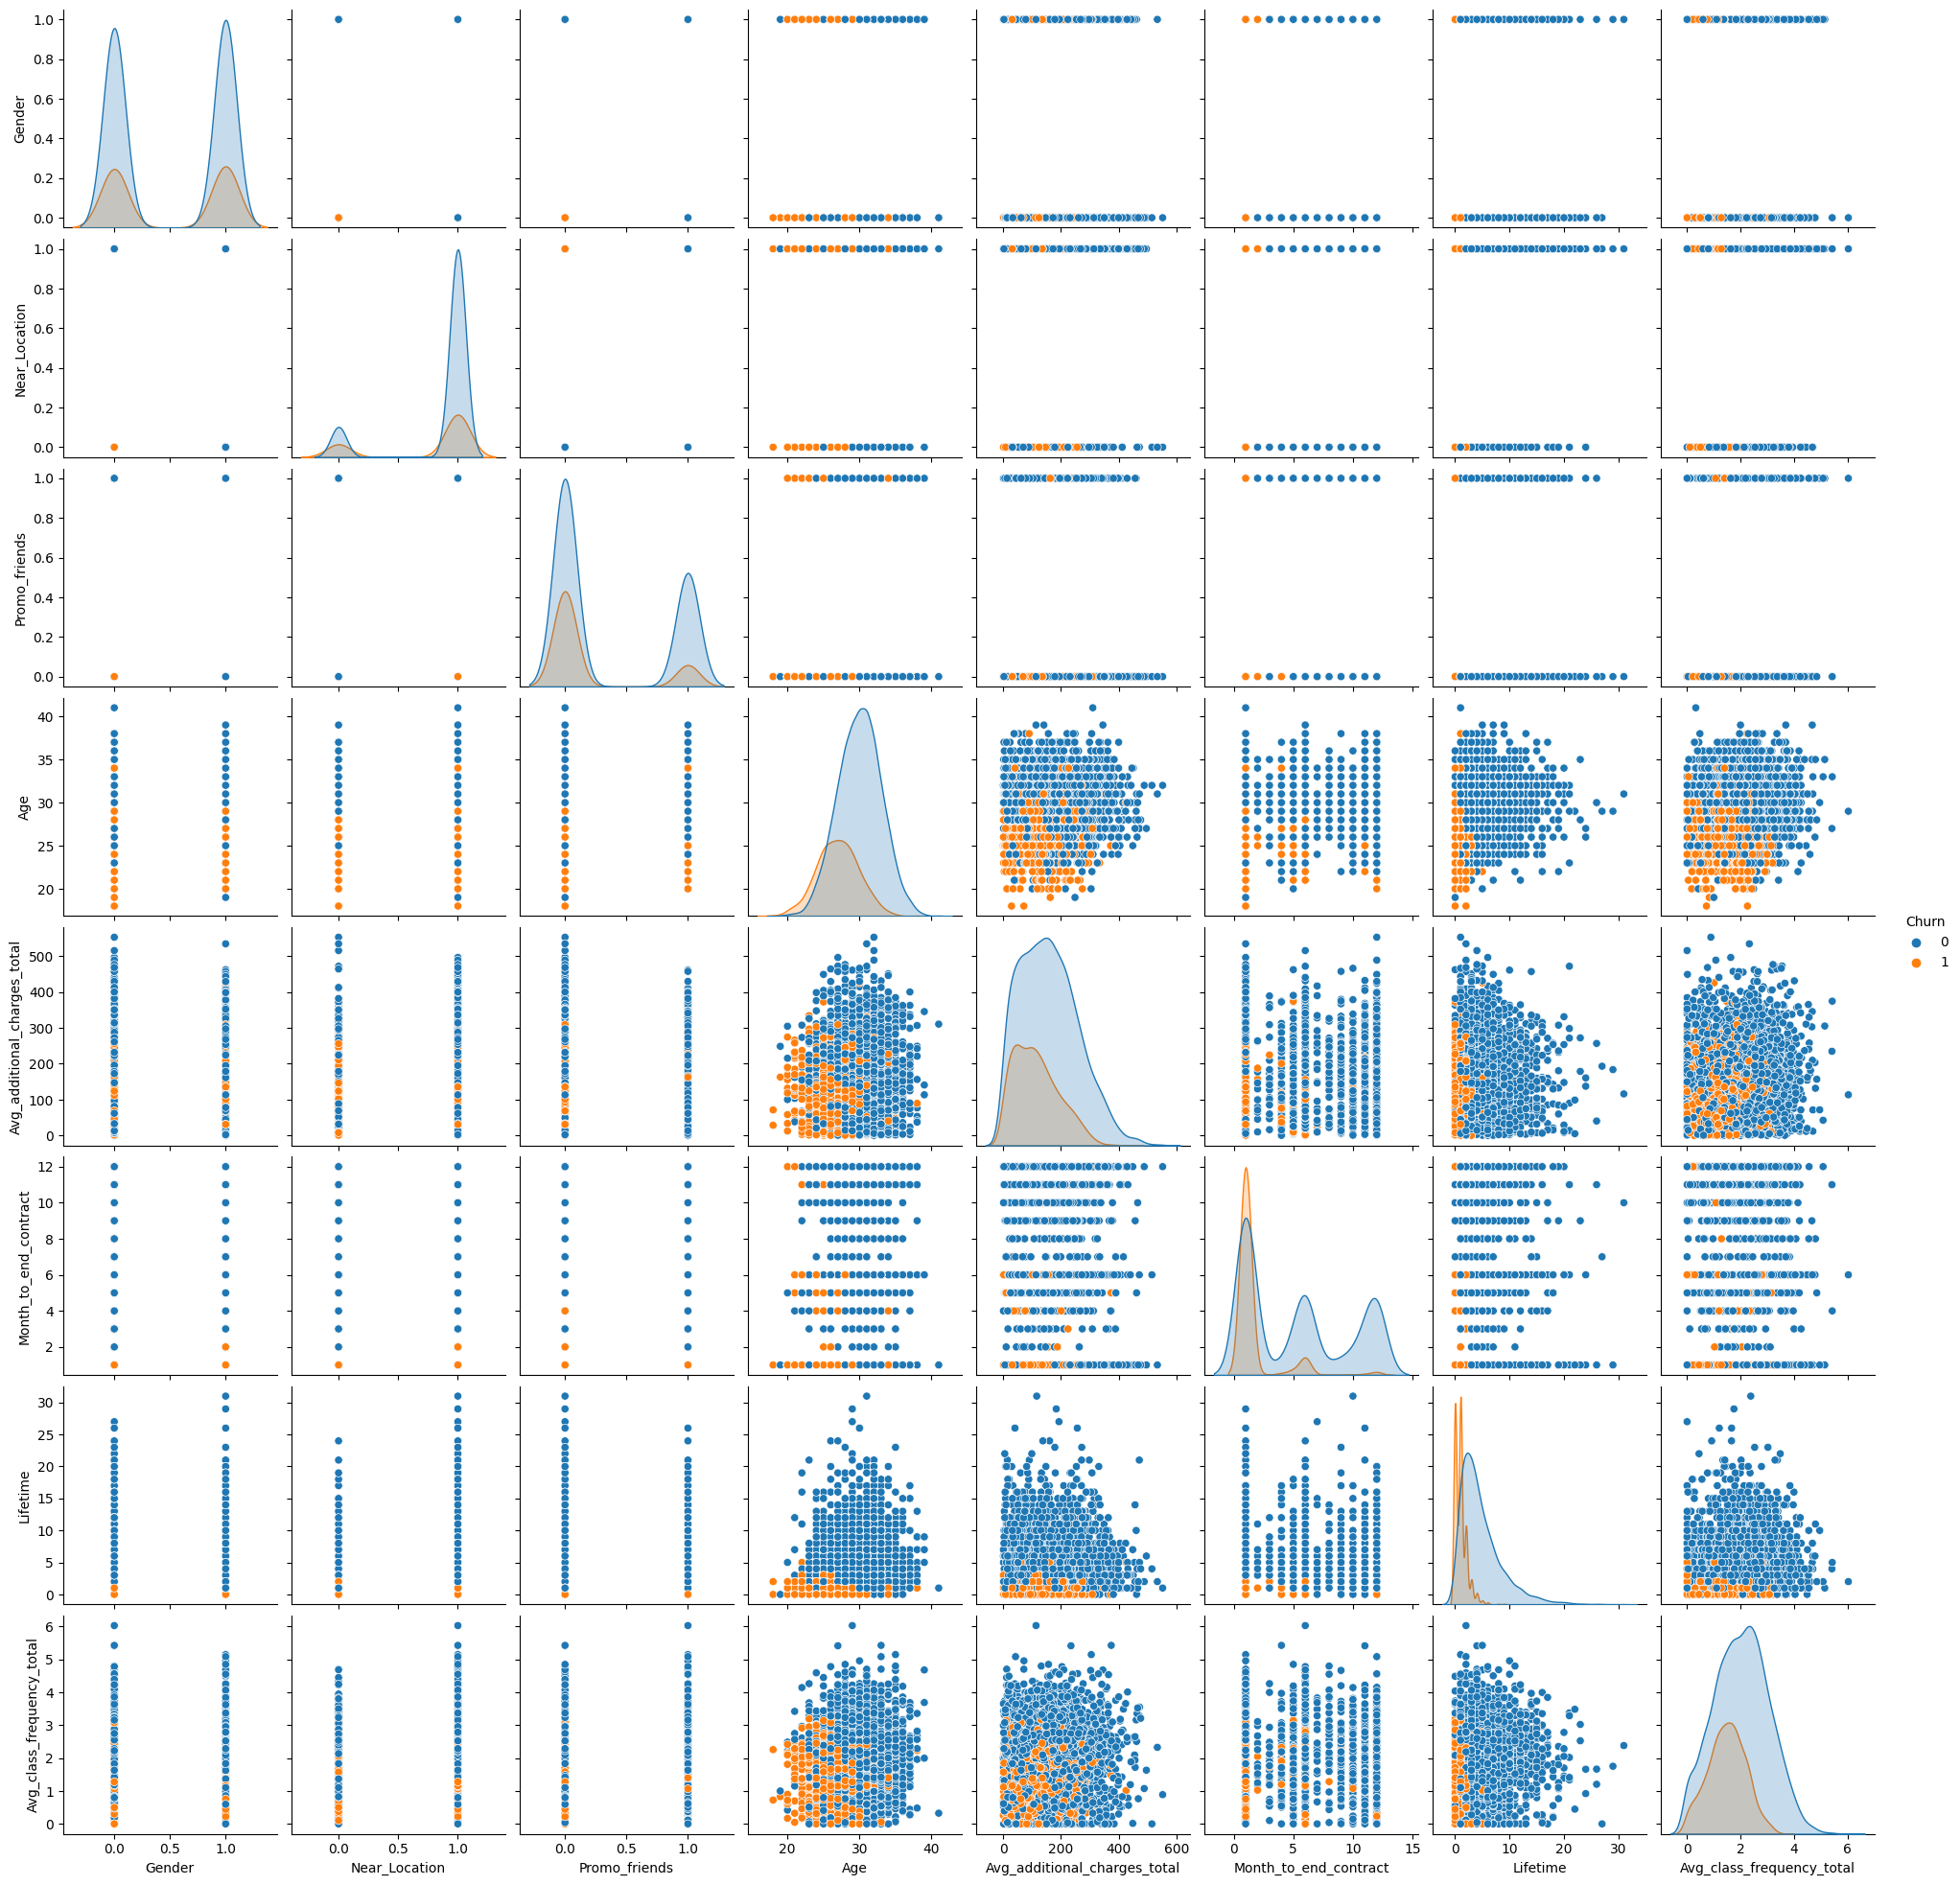

In [5]:
sns.pairplot(data = df[['Gender','Near_Location','Promo_friends','Age',
                       'Avg_additional_charges_total','Month_to_end_contract','Lifetime','Avg_class_frequency_total', 
                       'Churn']], hue='Churn')

На графике красным отмечены люди, ушедшие из клуба, а синим - оставшиеся. Например, монжо посмотреть на распредеелние параметров и увидеть несколько параметров: как распределены значения, и как распределены ушедшие и не ушедшие люди. Так, можно сделать некоторые выводы о том, что ушедшие клиенты тратили меньше, большинство уходило, проходив мало времени, а также ушедшие люди редко ходили на занятия.

Однако, наиболее важной информацией является тот факт, что Churn почти всегда скучен в одном месте, что позволяет всю эту группу выделить в отдельный кластер. Однако так как эта группа находится внутри другой, то сама кластериация будет достаточно сложной задачей.

Далее, перед кластеризацией, необходимо стандартизировать данные. Так как поля могут принимать разнообразные значения, необходимо прежде всего нормализовать и стандартизировать их. Это можно сделать быстро при помощи встроенных функций библиотеки sklearn.
Итоговые нормализованные данные представлены переменной X_sc

In [17]:
#df_for_ka = df[['Gender','Age',
#                       'Avg_additional_charges_total','Month_to_end_contract','Lifetime','Avg_class_frequency_total',
#                       'Avg_class_frequency_current_month','Churn']]
df_for_ka = df[['Gender','Near_Location','Partner','Promo_friends','Phone','Contract_period','Group_visits','Age',
                       'Avg_additional_charges_total','Month_to_end_contract','Lifetime','Avg_class_frequency_total',
                       'Avg_class_frequency_current_month']]
sc = StandardScaler()
X_sc = sc.fit_transform(df_for_ka)
X_sc

array([[ 9.79705882e-01,  4.27880741e-01,  1.02686062e+00,
         1.49716101e+00, -3.05985201e+00,  2.89890141e-01,
         1.19403206e+00, -5.65537982e-02, -1.37753121e+00,
         1.61605012e-01, -1.93328628e-01, -1.91191971e+00,
        -1.67847198e+00],
       [-1.02071450e+00,  4.27880741e-01, -9.73842000e-01,
        -6.67930833e-01,  3.26813192e-01,  1.60882159e+00,
         1.19403206e+00,  5.57327322e-01, -3.50213249e-01,
         1.83194105e+00,  8.73680013e-01,  4.51756901e-02,
         1.36013699e-01],
       [-1.02071450e+00,  4.27880741e-01,  1.02686062e+00,
        -6.67930833e-01,  3.26813192e-01, -8.09219400e-01,
        -8.37498453e-01, -3.63494358e-01, -1.81592303e-01,
        -7.92872726e-01, -4.60080788e-01, -2.04926314e-02,
        -2.90185050e-02],
       [-1.02071450e+00,  4.27880741e-01,  1.02686062e+00,
         1.49716101e+00,  3.26813192e-01,  1.60882159e+00,
         1.19403206e+00,  1.17120844e+00, -8.74722369e-01,
         1.83194105e+00, -4.60080788e

При выводе результата стандартизации видно, что все поля были превращены в числа, причем даже те данные, которые ранее принимали значения от 0 до 1, или имели дискретные значения от 1 до 12(в случае месяцев)

Далее, был применен метод k-средних. Для этого, необходимо сначала построить график зависимости суммык квадратов расстояний от точек до центроидов кластеров от количества самих кластеров. Ниже представлен график

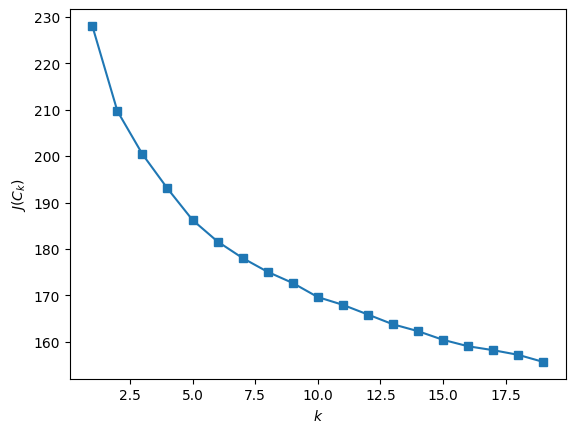

In [18]:
dots = []
for i in range(1,20):
    km = KMeans(n_clusters = i, random_state = 0)
    res = km.fit(X_sc)
    dots.append(np.sqrt(res.inertia_))
plt.plot(range(1, 20), dots, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

В итоге, на графике видно, что с увеличением количества кластеров идет достаточно плавное снижение квадрата расстояиния, поэтому, можно рассмотреть другой параметр: метрику силуэта. Попробуем построить тот же график, но по метрике.

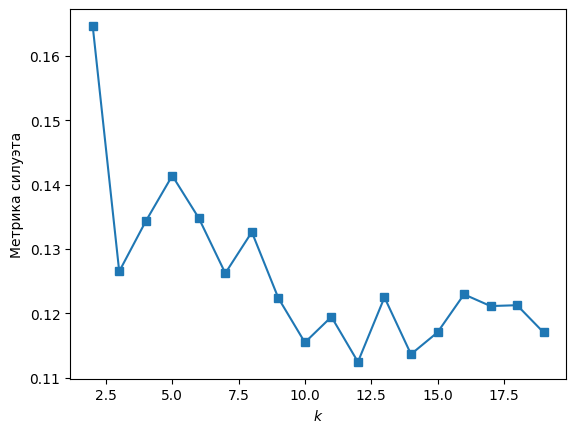

In [21]:
dots = []
for i in range(2,20):
    km = KMeans(n_clusters = i, random_state = 0)
    labels = km.fit_predict(X_sc)
    sc = silhouette_score(X_sc, labels)
    dots.append(sc)
    
plt.plot(range(2, 20), dots, marker='s');
plt.xlabel('$k$')
plt.ylabel('Метрика силуэта');

Видно, что максимальное значение достигается при количестве кластеров равном двум. А значит, лучше всего использовать именно 2 кластера. Далее, можно при помощи метода k-средних разбить данные на два кластера.

In [22]:
km = KMeans(n_clusters = 2, random_state = 0)
labels = km.fit_predict(X_sc)
u_labels = np.unique(labels)
print(u_labels)

print(X_sc[labels == 0 , 0])

[0 1]
[ 0.97970588 -1.0207145  -1.0207145   0.97970588 -1.0207145  -1.0207145
  0.97970588  0.97970588  0.97970588 -1.0207145  -1.0207145  -1.0207145
 -1.0207145  -1.0207145  -1.0207145  -1.0207145   0.97970588  0.97970588
 -1.0207145  -1.0207145  -1.0207145   0.97970588  0.97970588  0.97970588
 -1.0207145  -1.0207145   0.97970588 -1.0207145  -1.0207145  -1.0207145
  0.97970588 -1.0207145   0.97970588 -1.0207145   0.97970588  0.97970588
  0.97970588  0.97970588 -1.0207145  -1.0207145  -1.0207145  -1.0207145
 -1.0207145   0.97970588 -1.0207145   0.97970588  0.97970588 -1.0207145
  0.97970588 -1.0207145  -1.0207145   0.97970588  0.97970588  0.97970588
 -1.0207145  -1.0207145   0.97970588  0.97970588  0.97970588 -1.0207145
  0.97970588  0.97970588 -1.0207145   0.97970588  0.97970588 -1.0207145
 -1.0207145   0.97970588 -1.0207145  -1.0207145   0.97970588  0.97970588
  0.97970588 -1.0207145  -1.0207145   0.97970588 -1.0207145  -1.0207145
 -1.0207145  -1.0207145   0.97970588 -1.0207145   0.9

Далее, можно построить сводную таблицу по кластерам, и узнать разные характеристики параметров по кластерам. 

In [37]:
df_clusters = df
df_clusters['Clusters'] = labels
data_pivot = df_clusters.pivot_table(index = 'Clusters', aggfunc = 'mean')
data_pivot

Age  Avg_additional_charges_total  \
Clusters                                            
0         29.946685                    163.379857   
1         28.744580                    137.465582   

          Avg_class_frequency_current_month  Avg_class_frequency_total  \
Clusters                                                                 
0                                  2.135405                   2.147120   
1                                  1.554635                   1.724416   

             Churn  Contract_period    Gender  Group_visits  Lifetime  \
Clusters                                                                
0         0.032809         9.807929  0.516063      0.543404  4.797676   
1         0.399291         1.724872  0.506898      0.336618  3.106031   

          Month_to_end_contract  Near_Location   Partner     Phone  \
Clusters                                                             
0                      8.961039       0.935065  0.740943  0.898154   
1                      1.648009       0.793457  0.340166  0.906583   

          Promo_friends  
Clusters                 
0              0.529050  
1              0.181317

В итоге видно, что в 0 кластер попали те, кто не ушел из клуба, а во второй - те, кто ушел. Однако, так как значения ушедших много меньше половины, то во втором кластере 40% - ушедших из клуба. Однако все равно, несмотря на то, что изначально данного параметра не было, удалось разбить на кластеры таким образом, чтобы предсказать тех, кто может уйти из клуба. 

Наконец, можно определить какие из полей дали наибольшее влияние на формирование кластеров. Для этого, можно воспользоваться методом RandomForestClassifier(), в котором можно  одним из параметров: feature_importances_ вывести степень важности атрибутов. В последствии, эта "важность" используется для построения графика

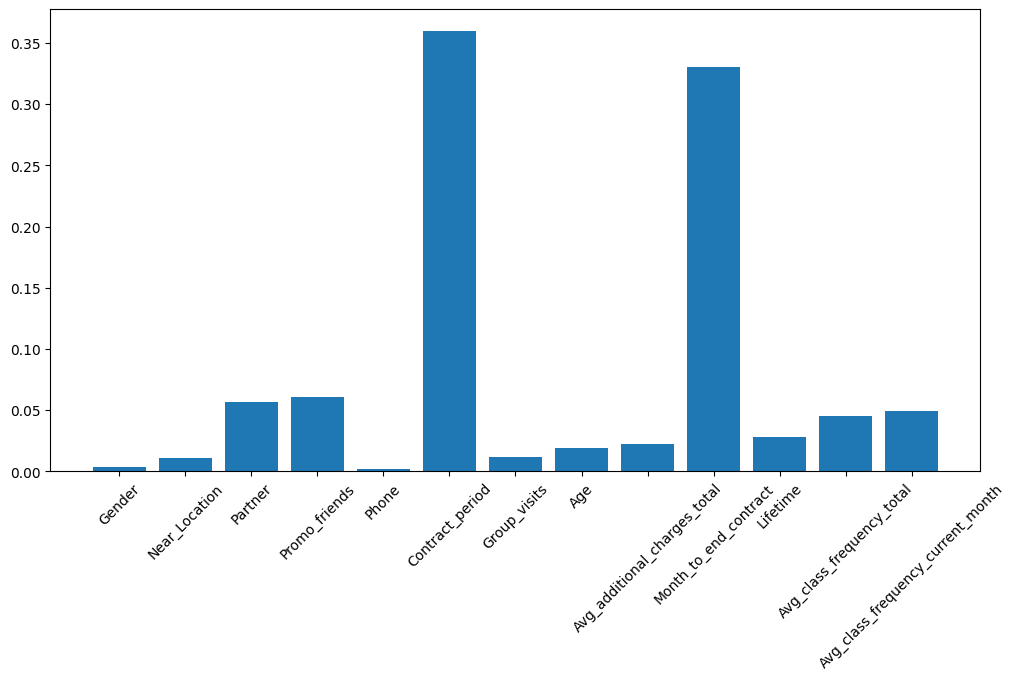

In [15]:
km2 = KMeans(2,random_state = 0)
km2.fit(X_sc)

clf = RandomForestClassifier()
clf.fit(X_sc, km2.labels_)

plt.figure(figsize=(12,6))
plt.bar(df_for_ka.columns, clf.feature_importances_)
plt.xticks(rotation=45)

plt.show()

В итоге, можно сделать вывод о том, что наиболее важными параметрами, которые повлияли на разбиение методом k-средних являются: период контракта, средние дополнительные затраты. Остальные параметры не сильно повлияли при разбиении на кластеры.

Можно сделать промежуточные выводы по данному методу. Данный метод смог без особых затруднений разбить набор данных таким образом, чтобы в одном кластере были те, кто может уйти из клуба, и тех, кто не ушел. Однако, для того чтобы его можно было разбить на нужное количество кластеров, необходимо проводить предварительный анализ (при помощи квадрата расстояний между точкой и центроидом или при помощи метрик).

Следующим исследуемым методом является **иерархический агломеративый метод**

Данный метод имеет некоторое преимущество по сравнению с k-средних: данный метод не требует предварительного расчета количества кластеров, вместо этого он сам определяет сколько кластеров требуется. 

Для того, чтобы построить данным методом кластеры, необходимо создать таблицу связон между объектами, чтобы в послествии можно было определить где и какой объект находится. Ниже представлен код для создания кластеров и их визуальное отображение

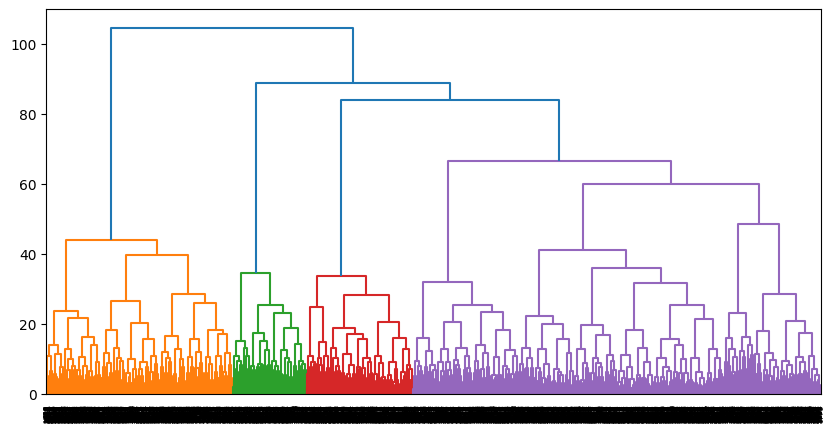

In [16]:
linked = linkage(X_sc,method = 'ward')
plt.figure(figsize=(10, 5))
dn = dendrogram(linked)

В итоге видно, что получилось 4 кластера (по разным цветам), которые обозначают разную группу объектов, объединенных одним признаком.

Так как кластеры, в данном случае, являются гигантскими, рассмотрим какие из параметров повлияли больше всего на формирование кластеров. Это выполняется аналогично предыдущему способу.

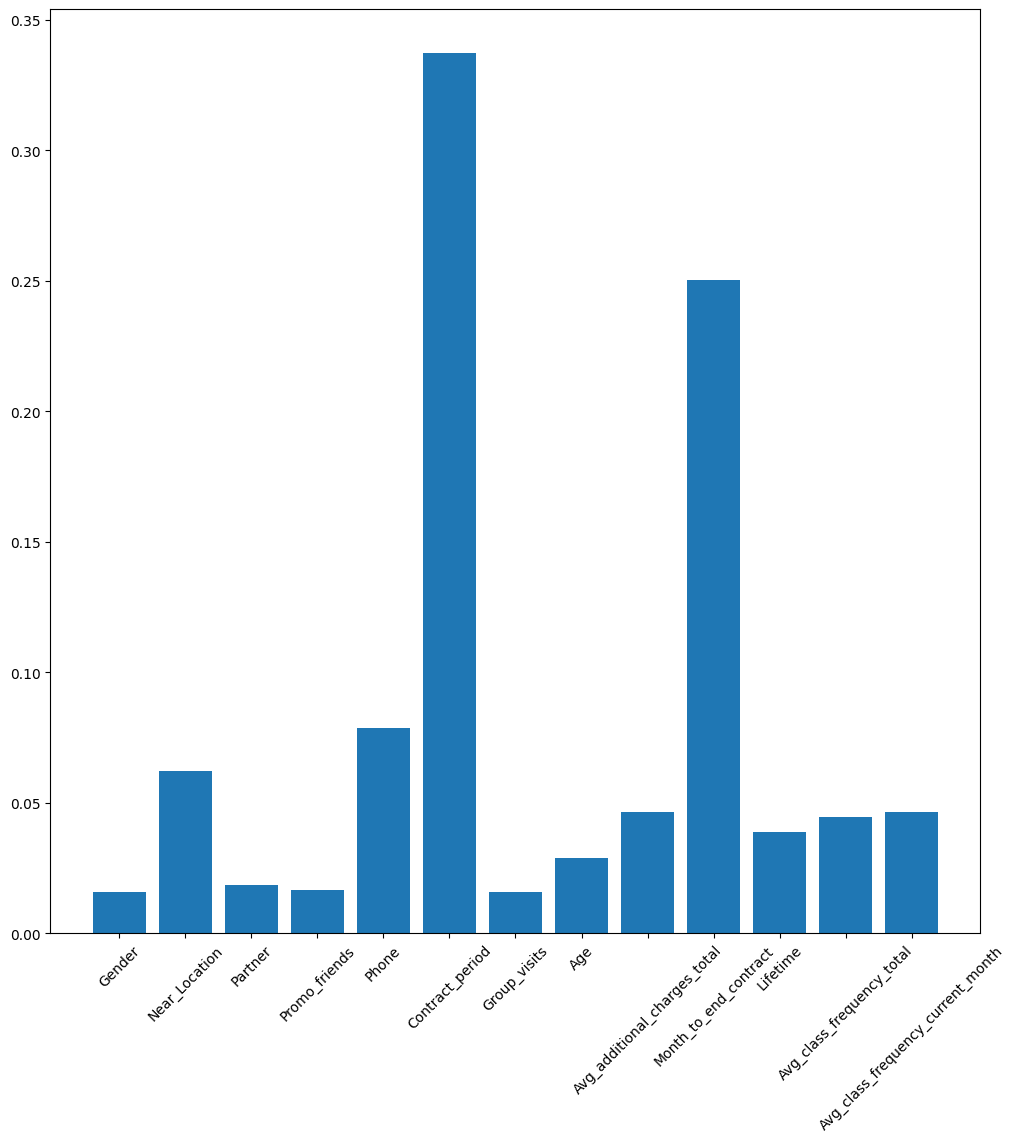

In [18]:
km2 = AgglomerativeClustering()
km2.fit(X_sc)

clf = RandomForestClassifier()
clf.fit(X_sc, km2.labels_)

plt.figure(figsize=(12,12))
plt.bar(df_for_ka.columns, clf.feature_importances_)
plt.xticks(rotation=45)

plt.show()

По графику можно увидеть, что критериями, наиболее сильно повлиявшими на кластеры являются: период договора, а также средние затраты на дополнительные услуги.

Интересно то, что несмотря на то, что в данном случае выделились 4 кластера, влияющими признаками оказалить те же самые признаки, что и в k-means, а значит, данные признаки действительно являются определяющими в данном наборе данных.

Таким образом, можно сделать промежуточный вывод о том, что иерархический агломеративный метод с визуальной точки зрения выглядит нагляднее, чем метод K-точек, особенно при данном наборе. Однако, минусом данного метода является то, что при особенно больших наборах с большим количеством параметров крайне сложно отследить отдельные объекты по названиям.

Кроме этого, при помощи метрик качества кластеризации можно понять: насколько хорошо работает та или иная кластеризация. В основе метрики силуэта положен анализ расстояния между объектами и расстояние между кластерами. Как уже понятно, эти параметры являются ключевыми, так как чем кучнее находятся объекты, тем более явно видны кластеры, а значит, кластеризация выполнена лучше и точнее.

Ниже представлен код по анализу при помощи метрики силуэта. В первом случае анализируется метод k-средних, во втором случае - иерархический агломеративный метод

In [23]:
silhouette_score(X_sc, labels)

0.1646818271752276

In [24]:
silhouette_score(X_sc, km2.labels_)

0.11698964081320212

Таким образом видно, что более точным оказался метод k-средних, но всего на 0.05. Так как значения далеко от единицы, это говорит о том, что построенные кластеры находятся далеко от идеальных, но все же эти методы можно использовать для кластеризации методов.

**Выводы**:


В результате проведенной работы были изучены методы и способы кластеризации данных, а также получены навыки по применению полученных данных для анализа набора данных.

Кластеризация - это процесс, который позволяет объединять обекты в отдельные группы (кластеры) по определенным параметрам для каждого из полей. В связи с этим, первым важным применением является поиск объектов, связанных друг с другом и которые могут так или иначе влиять друг на друга или на весь кластер в целом.

Полученные кластеры можно не только анализировать, но и при добавлении новых данных использовать старые кластеры, и добавлять туда новые данные. Это также позвояет сгруппировать данные.

В ходе работы был проанализирован набор данных без целевого признака - churn. Однако, даже несмотря на то, что данного признака не было, на примере K-means было выявлено, что кластеры почти четко были созданы по данному целевому признаку: в один кластер попали те, кто вышел из клуба, а во второй те, кто еще не вышел. Однако, несмотря на это, в кластере с ушедшими из клуба также находились люди, которые не ушли. Возможно, это как раз является признаком того, что данные люди вскоре могут уйти из клуба.

Другой метод - агломеративная иерархическая кластеризация, также выполнил кластеризацию, но в более ясном визуальном виде. Однако, из-за большого количества параметров итог крайне трудно разглядеть из-за большого набора данных, каждый из которых могут так или иначе повлиять на результат.

В конце было выявлено, что метод k-means с 2 класерами оказался более верным, чем второй метод. Это было выявлено при помощи метрики силуэта, так как первый метод оказался на 0.05 более верным, чем второй. Однако, оба этих метода могут вполне использоваться вместе: один для получения точных числовых параметров-результатов, а второй для визуального отображения результата кластеризации.

Таким образом. кластеризация позволяет выявить определенные группы разбиения, которые, в последствии, позволяют предсказать будущие результаты по целевому признаку при появлении новых данных.

